# Quantum Real Time Evolution using Trotterization

As a real time evolution technique, the Trotterization or Trotterized Real Time Evolution (RTE) consists in the successive application of a quantum gate, assumed to approximate the time evolution of a system for a time slice [1]. Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $h_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

In this tutorial, we will implement real time evolutions using the Qiskit `TrotterQRTE` class. To illustrate this, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on linear lattices of $L=2$ and $L=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. These spins can have two orientations: $\uparrow$ and $\downarrow$, which correspond to a magnetization of $+1$ and $-1$ respectively.

$$
H = - J \sum_{i=0}^{L-2} \sigma_i \sigma_{i+1} - h \sum_{i=0}^{L-1} \sigma_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field. Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction,

$$
H = -J \sum_{i=0}^{L-2} Z_i Z_{i+1} -h \sum_{i=0}^{L-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

In the computational basis, the system will be encoded as follows:

| Quantum state            | Spin representation                        |
|:------------------------:|:------------------------------------------:|
| $\lvert 0 0 0 0 \rangle$ | $\uparrow\uparrow\uparrow\uparrow$         |
| $\lvert 1 0 0 0 \rangle$ | $\downarrow\uparrow\uparrow\uparrow$       |
| $\ldots$                 | $\ldots$                                   |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

First, we will create a function that takes in the system parameters $L$, $J$, $h$ and $\alpha$, and returns our Hamiltonian as a `SparsePauliOp`. A [`SparsePauliOp`](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html) is a sparse representation of an operator in terms of weighted [`Pauli`](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Pauli.html) terms.

In [1]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):
    
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

Let us get started, and create a Hamiltonian as an operator for $L=2$, and a choice of $J=0.2$, $h=1$ and $\alpha=\pi/8$:

In [2]:
from math import pi

H = get_hamiltonian(L=2, J=.2, h=1., alpha=pi/8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

Let us create an instance of `TimeEvolutionProblem`. Conceptually, it contains all the information relevant on the physical problem. In our case, we will pass it the our Hamiltonian, an initial state, a final time. As initial state, we will take a spin up and a spin down.

In [3]:
from qiskit.quantum_info import Statevector
from qiskit.algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label('10')

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

Qiskit Nature allows us to visualize our 2-site lattice, along with the initial spin directions that we have added to it.

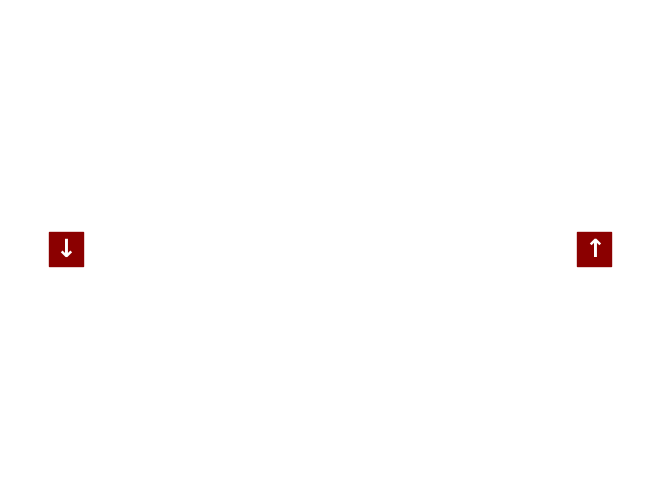

In [4]:
from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition, LatticeDrawStyle

# Function that takes in a string of '0' and '1', representing an initial
# state, written in the computational basis, and returns a callable that,
# in turn, takes in a lattice site index and returns an arrow pointing
# up or down, depending of the orientation of the spin, according to the
# initial string of '0' and '1'
def get_callable_index_to_spin(initial_state_computational_basis):
    initial_state_spins = initial_state_computational_basis.replace('0', '↑').replace('1', '↓')
    def index_to_spin(index):
        return initial_state_spins[index]
    return index_to_spin

boundary_condition = BoundaryCondition.OPEN
lattice = LineLattice(num_nodes=2, boundary_condition=boundary_condition)
lattice_style = LatticeDrawStyle(node_shape='s', node_size=600, node_color='darkred', width=0,
                         font_color='w', font_weight='bold', font_size=18,
                         with_labels=True, labels=get_callable_index_to_spin('10'))
lattice.draw(style=lattice_style)

We can now create an instance of `TrotterQRTE`. Conceptually, it contains the information relevant to solve a physical problem, which does by means of the method `evolve`.

In [5]:
from qiskit.algorithms.time_evolvers.trotterization.trotter_qrte import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

Our evolved state is in the result's attribute `evolved_state`, which is a `QuantumCircuit`,

In [6]:
result.evolved_state

The evolved state, like all `QuantumCircuit`s, can be turned into a `Statevector`.

In [7]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


Let us find out the effect of the field direction after a certain a certain time $t=1.6$. Note that the units of time are the inverse of the units of the Hamiltonian. For the purposes of this tutorial we leave all units dimensionless.

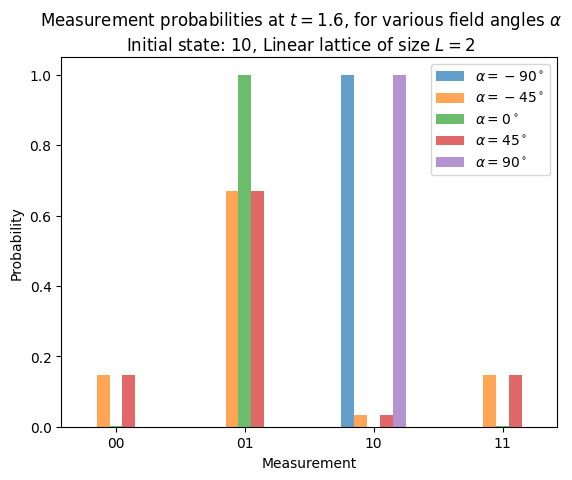

In [8]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = .1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=.2, h=1., alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

We have prepared a system initially with a sequence of spins $\uparrow\downarrow$, which corresponds to $\vert\psi(0)\rangle = \vert01\rangle$. After letting it evolve for $t=1.6$ under a transversal field ($\alpha=0^\circ$), we are almost guaranteed to measure $\downarrow\uparrow$, i.e. have a spin swap. (Note that the labels are interpreted from right to left). If the field is longitudinal ($\alpha=\pm90^\circ$), we will have no evolution, therefore we will measure the system as it was initially prepared, $\uparrow\downarrow$. With intermediate angles, at $\alpha=\pm45^\circ$, we will be able to measure all combinations will different probabilities, being a spin swap the most likely with a probability of 67%.

### Auxiliary operators

Let us look into another feature of `TrotterQRTE`. We will now explore its ability to perform time evolutions of a system, while keeping track of some observables. The system that we now consider has a size of $L=6$.

In [9]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=.2, h=1.2, alpha=pi/8)

Again, Qiskit Nature allows us to visualize our lattice.

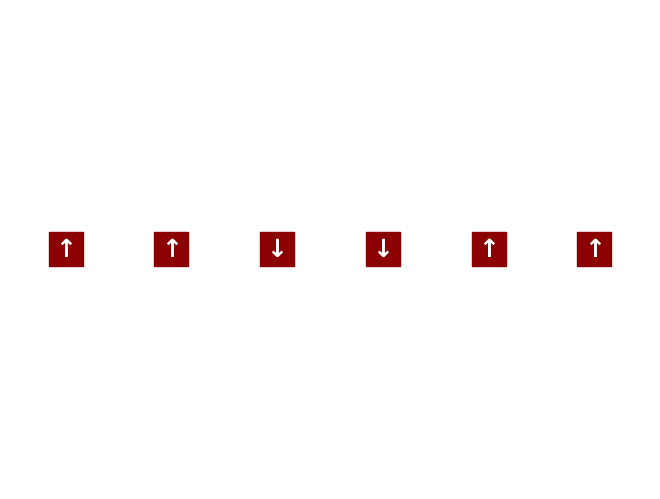

In [10]:
boundary_condition = BoundaryCondition.OPEN
lattice = LineLattice(num_nodes=L, boundary_condition=boundary_condition)
style = LatticeDrawStyle(node_shape='s', node_size=600, node_color='darkred', width=0,
                         font_color='w', font_weight='bold', font_size=18,
                         with_labels=True, labels=get_callable_index_to_spin('001100'))
lattice.draw(style=style)

The `TrotterQRTE` instance now will be created with a `num_timesteps` argument, and an `Estimator` primitive. The Qiskit's `Estimator` primitive estimates expectation values of observables, $\langle\psi\vert\hat{O}\vert\psi\rangle$.

In [11]:
from qiskit.algorithms.time_evolvers.trotterization.trotter_qrte import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

Let us define a *magnetization operator* $\sum_i Z_i$, and a *mean spin correlation operator* $\sum_i Z_i Z_{i+1} / (L - 1)$.

In [12]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.) for i in range(0, L-1)], num_qubits=L) / (L - 1)

Our new initial state will have the two middle spins facing down, and the `TimeEvolutionProblem` will incorporate some observables that will be kept track of:
1. the energy, i.e. the expectation value of the Hamiltonian, $\langle H\rangle$
2. the magnetization, $\langle \sum_i Z_i \rangle$
3. the mean spin correlation, $\langle\sum_i Z_i Z_{i+1}\rangle/(L-1)$

In [13]:
final_time = 30.
initial_state = Statevector.from_label('001100')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])

Again, we let our `TrotterQRTE` evolve our newly created problem instance.

In [14]:
result = trotter.evolve(problem)

The new result also features an `observables` attribute. Let's extract the observables stored in it.

In [15]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

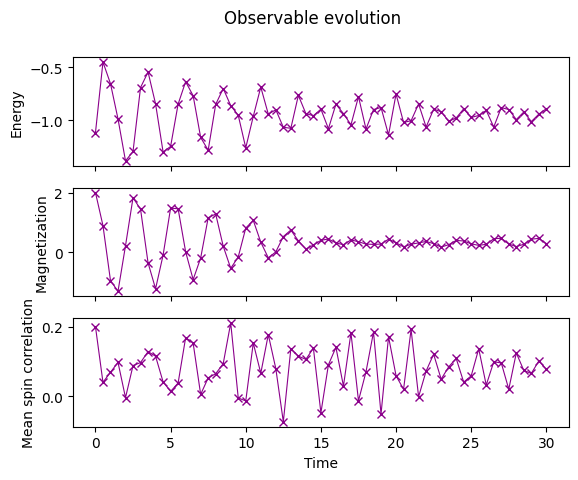

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

Let us verify these results by comparing these expected values using Trotter evolution with the exact ones. To that end, we evaluate directly the expression discussed in the introduction,

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

on each one of the timesteps used by Trotter. We compute this exponential using scipy's [`linalg.expm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) function, and then we let the initial system evolve using the `Statevector`'s [`evolve` method](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.evolve.html). This becomes too costly to be performed on larger systems very quickly.

In [17]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

Having the exact state vectors, we compute the exact evolution of our operators' expectation values.

In [18]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

We incorporate the exact evolution of the operators alongside the expected values resulting from the Trotterization.

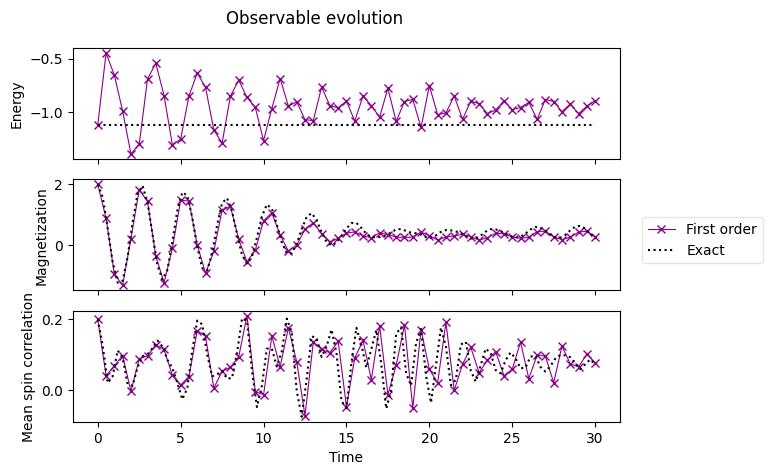

In [19]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
# Select the labels of only the first axis
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig

We see that, as an approximation, a Pauli-Trotter evolution isn't too far from the exact solution, but the accuracy is limited. Let's see how to find higher order formulas to address this.

### Product formula overview

If it isn't specified, the default product formula that `TrotterQRTE` uses is the Lie product formula [2], which is at first order. In Qiskit this is implemented in the [`LieTrotter` class](https://qiskit.org/documentation/stubs/qiskit.synthesis.LieTrotter.html). A first order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{A+B} \approx e^A e^B
$$

Knowing this, we can have a look at the circuit that performs a single Trotter step.


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 7
             Gate count: 17
    Nonlocal gate count: 5
         Gate breakdown: RZ: 6, RX: 6, RZZ: 5



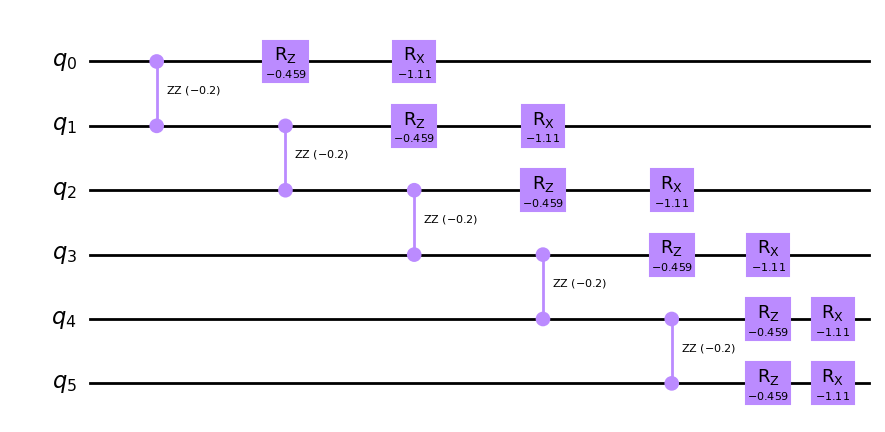

In [21]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
""")

# And finally draw the circuit
circuit.draw('mpl')

There exists a second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [`SuzukiTrotter` class](https://qiskit.org/documentation/stubs/qiskit.synthesis.SuzukiTrotter.html). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




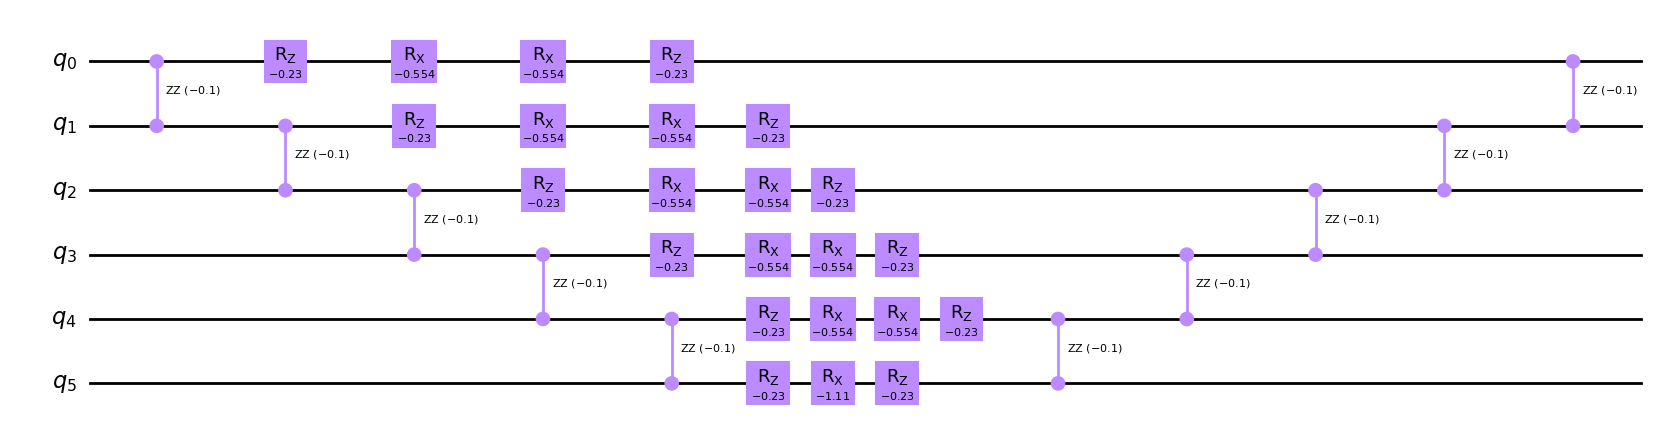

In [22]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter() # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")

# And finall
circuit.draw('mpl')

In [23]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




Finally, let us perform a simulation at fourth order.

In [24]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

and plot the results.

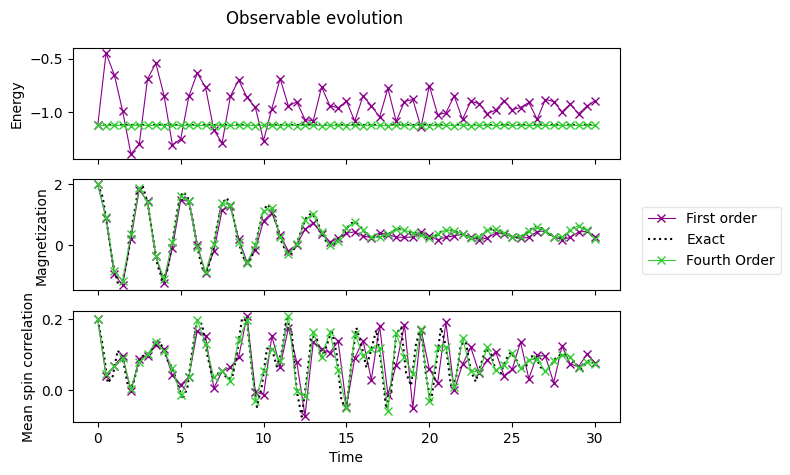

In [25]:
axes[0].plot(times, observables_order4[:, 0], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[1].plot(times, observables_order4[:, 1], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[2].plot(times, observables_order4[:, 2], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)

# Replace the legend
legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig

As it is to expect, we can directly see that a higher-order product formula leads to more accurate expectation values.

### Colorplot

In this last step, we aim at visualizing the time evolution of each one of the sites of the lattice individually. Let us present the expected value of the magnetization of each one of the sites as a function of time in a color plot. As the initial state was $\vert\psi(0)\rangle = \vert001100\rangle$ (spin sequence $\uparrow\uparrow\downarrow\downarrow\uparrow\uparrow$), at time $t=0$ we expect to see magnetization $-1$ in the two middle signs and $+1$ elsewhere. During the evolution, as the plot above suggests, we can expect to see oscillations which will eventually damp.

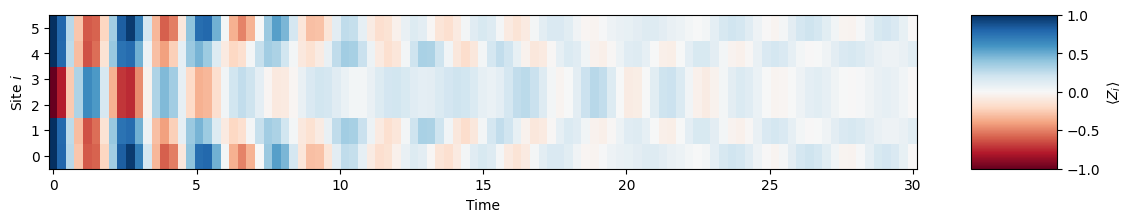

In [26]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real([[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution])
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap='RdBu')
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel('Site $i$')
plt.xlabel('Time')
plt.colorbar(label='$\\langle Z_i \\rangle$', aspect=1.8)

## References

[1] Hatano, Naomichi, and Masuo Suzuki. "Finding exponential product formulas of higher orders." _Quantum annealing and other optimization methods._ Berlin, Heidelberg: Springer Berlin Heidelberg, 2005. 37-68.

[2] Varadarajan, Veeravalli S. _Lie groups, Lie algebras, and their representations._ Vol. 102. Springer Science & Business Media, 2013.

[3] Magnus, Wilhelm. "On the exponential solution of differential equations for a linear operator." _Communications on pure and applied mathematics_ 7.4 (1954): 649-673.

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright